# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("./data/Train_rev1/Train_rev1.csv", index_col=None)
#TODO : check id field
data.shape

(244768, 12)

In [3]:
data.head()

Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          NaN   
2  Hampshire, South East, South East          Hampshire          NaN   
3     Surrey, South East, South East             Surrey          NaN   
4     Surrey, South East, South East             Surrey          NaN   

  ContractTime                       Company          Category  \
0    permanent  Gregory Martin International  Engineering Jobs   
1    permanent  Gregory Martin International  Engineering Jobs   
2    permanent  Gregory Martin International  Engineering Jobs   
3    permanent  Gregory Martin International  Engineering Jobs   
4    permanent  Gregory Martin International  Engineering Jobs   

                                SalaryRaw  SalaryNormalized        SourceName  
0              20000 - 30000/annum 20-30K             25000  cv-library.co.uk  
1              25000 - 35000/annum 25-35K             30000  cv-library.co.uk  
2              20000 - 40000/annum 20-40K             30000  cv-library.co.uk  
3  25000 - 30000/annum 25K-30K negotiable             27500  cv-library.co.uk  
4              20000 - 30000/annum 20-30K             25000  cv-library.co.uk

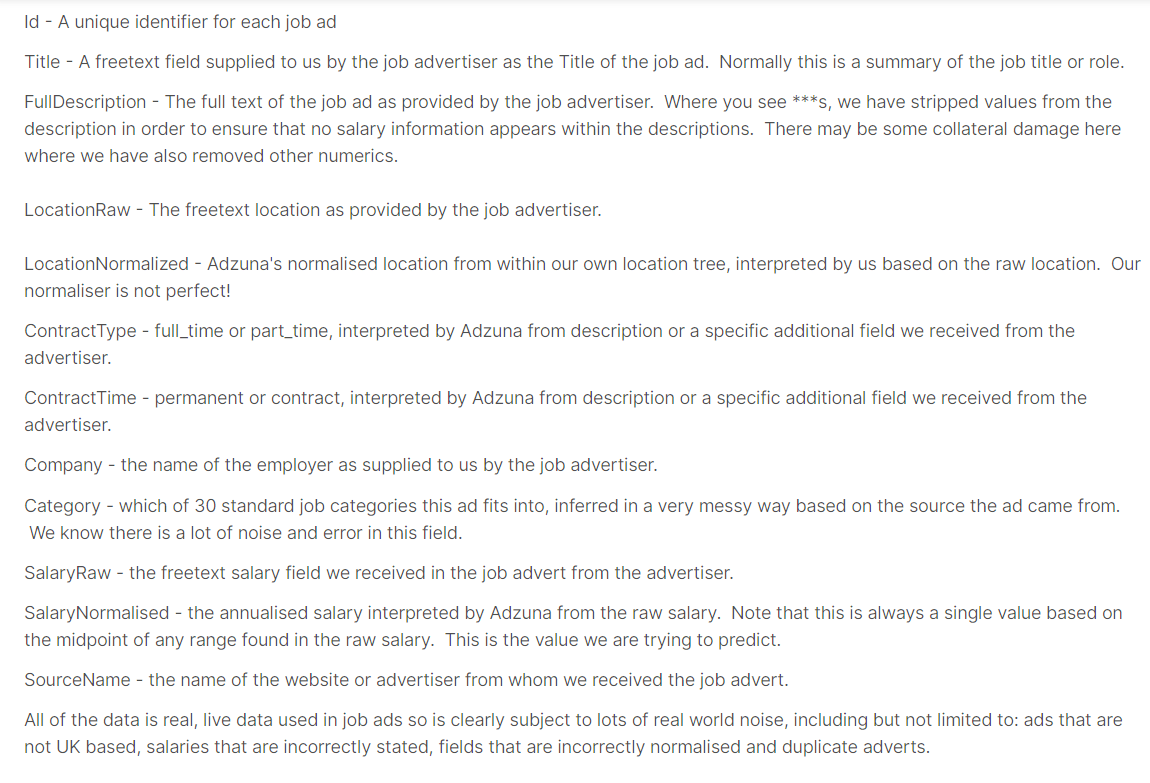

In [4]:
data['FullDescription'].values[2]

'Mathematical Modeller / Simulation Analyst / Operational Analyst Basingstoke, Hampshire Up to ****K AAE pension contribution, private medical and dental The opportunity Our client is an independent consultancy firm which has an opportunity for a Data Analyst with 35 years experience. The role will require the successful candidate to demonstrate their ability to analyse a problem and arrive at a solution, with varying levels of data being available. Essential skills Thorough knowledge of Excel and proven ability to utilise this to create powerful decision support models Experience in Modelling and Simulation Techniques, Experience of techniques such as Discrete Event Simulation and/or SD modelling Mathematical/scientific background  minimum degree qualified Proven analytical and problem solving skills Self Starter Ability to develop solid working relationships In addition to formal qualifications and experience, the successful candidate will require excellent written and verbal communi

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

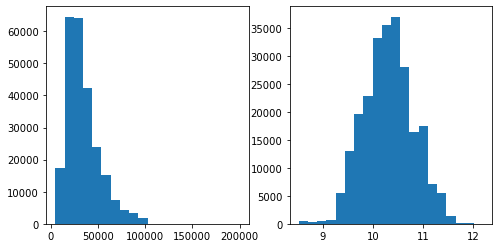

In [5]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

Id                                            Title  \
93784   69192251                                 YPD Unit Manager   
96617   69250351                     FX Corporate Sales executive   
158382  71130869  NHS Procurement Manager  Any Qualified Provider   

                                          FullDescription  \
93784   Our client is a medium sized healthcare organi...   
96617   Our client is a Tier **** foreign exchange pro...   
158382  I am currently recruiting for a Procurement Ma...   

                           LocationRaw LocationNormalized ContractType  \
93784                   Merthyr Tydfil     Merthyr Tydfil    full_time   
96617                           London             London          NaN   
158382  Greater London, Central London             London          NaN   

       ContractTime               Company                   Category  \
93784     permanent   Recruiting for Care  Healthcare & Nursing Jobs   
96617     permanent  Arthur Financial Ltd  Accounting & Finance Jobs   
158382          NaN         Real Staffing         Other/General Jobs   

                     SalaryRaw  SalaryNormalized        SourceName  \
93784                   28,000             28000       fish4.co.uk   
96617   Basic 34-40,000 + comm             37000     jobsite.co.uk   
158382    50,000-74,999 yearly             62499  theladders.co.uk   

        Log1pSalary  
93784     10.239996  
96617     10.518701  
158382    11.042922

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [7]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [8]:
import en_core_web_sm

nlp = en_core_web_sm.load(disable=['tok2vec'])

In [9]:
nlp.pipe_names

['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']

In [10]:
def tokenizer(Series, replace_ent = True):
    all_tokens = []
    for doc in nlp.pipe(Series.str.lower().values, batch_size=100, n_process=8):
        if doc.has_annotation("DEP"):
            new_doc = []
            for token in doc:
                if token.lemma_ == '-PRON-':
                    new_doc.append('-PRON-')
                elif token.is_stop==True:
                    pass
                elif token.is_punct==True:
                    pass
                elif token.pos_=='SPACE':
                    pass
                elif (token.text in [i.text for i in doc.ents]) and replace_ent:
                    for ent in doc.ents:
                        if token.text == ent.text:
                            new_doc.append(ent.label_)
                else:
                    new_doc.append(token.lemma_)
            all_tokens.append(' '.join(new_doc))
        else:
            all_tokens.append(None)
    return pd.Series(all_tokens)

In [11]:
data[['Title']].head(100).apply(tokenizer)

Title
0                         engineering systems analyst
1                             stress engineer glasgow
2                        modelling simulation analyst
3   engineering systems analyst mathematical modeller
4           pioneer miser engineering systems analyst
..                                                ...
95           chef de parties required nationwide live
96                   chef de partie norfolk live tips
97                    plastic extrusion setter nights
98       assistant manager suffolk coastal restaurant
99                            cluster revenue manager

[100 rows x 1 columns]

In [12]:
%%time
data[text_columns] = data[text_columns].apply(tokenizer)

CPU times: user 1h 20min 3s, sys: 1min 16s, total: 1h 21min 19s
Wall time: 1h 26min 28s


In [14]:
data.shape

(244768, 13)

Now we can assume that our text is a space-separated list of tokens:

In [15]:
data["FullDescription"][2][:50]

'mathematical modeller simulation analyst operation'

In [16]:
data["Title"][54321]

'international digital account manager german'

In [17]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
#assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / operation'
#assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller simulation analyst opera...
100002    successful high achieving specialist school GP...
200002    web designer html css javascript photoshop ill...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [18]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [19]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 243360
('experience', 426713)
('role', 291573)
('work', 279634)
('business', 275137)
('team', 270636)
...
('n.p.q.h', 1)
('andy.lowehays.com', 1)
('enthusiasm.if', 1)


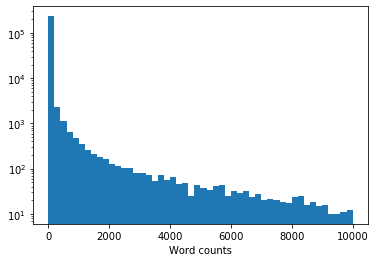

In [20]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [21]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = [t for t, c in token_counts.items() if c >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
tokens

In [23]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
#assert len(tokens) in range(32000, 35000)
#assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34924
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [68]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [ ]:
token_to_id

In [70]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [71]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [72]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec&i engineer

Matrix:
[[    2     3     4]
 [  996   159     1]
 [   15 11736     6]]


In [73]:
print("Lines:")
print('\n'.join(data["FullDescription"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["FullDescription"][::100000]))

Lines:
engineering systems analyst dorking surrey salary ****k client located dorking, surrey looking engineering systems analyst client provides specialist software development keywords mathematical modelling, risk analysis, system modelling, optimisation, miser, pioneeer engineering systems analyst dorking surrey salary ****k
looking hr advisor join team maternity cover. role time, monday friday. successful candidate proven track record working hr, preferably education sector. responsible keeping college employee database date providing general hr support members hr team (arranging meetings, preparing paperwork etc). candidates excellent communication skills (both written oral), excellent oraganisational skills ability deal sensitively tactful manner staff external applicants. cipd qualification knowledge recruitment staff development administration highly desirable role
client, leading power generation business based scotland, seeking lead ec engineer join success growing business. 

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [76]:
data.nunique()

Id                    244768
Title                 128703
FullDescription       241012
LocationRaw            20986
LocationNormalized      2732
ContractType               3
ContractTime               3
Company                 1001
Category                  29
SalaryRaw              97286
SalaryNormalized        8454
SourceName               167
Log1pSalary             8454
dtype: int64

In [79]:
data['ContractTime'].value_counts()

permanent    151521
NaN           63905
contract      29342
Name: ContractTime, dtype: int64

In [77]:
categorical_columns

['Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime']

In [80]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")


top_locations, top_counts = zip(*Counter(data['LocationNormalized']).most_common(100))
recognized_locations = set(top_locations)
data["LocationNormalized"] = data["LocationNormalized"].apply(lambda loc: loc if loc in recognized_locations else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [86]:
data[categorical_columns].head()

Category                       Company LocationNormalized  \
0  Engineering Jobs  Gregory Martin International              Other   
1  Engineering Jobs  Gregory Martin International            Glasgow   
2  Engineering Jobs  Gregory Martin International          Hampshire   
3  Engineering Jobs  Gregory Martin International             Surrey   
4  Engineering Jobs  Gregory Martin International             Surrey   

  ContractType ContractTime  
0          NaN    permanent  
1          NaN    permanent  
2          NaN    permanent  
3          NaN    permanent  
4          NaN    permanent

In [81]:
categorical_vectorizer.transform(data[categorical_columns].head(5).apply(dict, axis=1))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [88]:
len(categorical_vectorizer.get_feature_names())

1136

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [89]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [92]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

#TODO: Look at it
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [112]:
make_batch(data_train[:5], max_len=10)

{'Title': tensor([[  15,   84,   30,  991, 1167],
         [1823,  215, 1798,  159,    1],
         [  91,   92,   78,    1,    1],
         [  24,   20,    1,    1,    1],
         [1764,    0,  464,    1,    1]]),
 'FullDescription': tensor([[ 7200,   417,  1638,   991, 14652, 53893,   275,    47,  1668,   991],
         [ 3956,  1486,    67,  1823,   947, 15354,   207,  4690, 11356, 11893],
         [23015, 18219,  1140,  6025,   968, 23579,    91, 18340,   197,  1218],
         [   24,    20,   348,  6479,  6479,   912,  2570,  7910, 13806,  7403],
         [ 1338,  3675,  1764,  5821,  4390,    22,   648,  4002, 19403,  2601]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631, 10.1659,  9.7982])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [117]:
import torch
import torch.nn as nn
import torch.functional as F

In [118]:
len(tokens)

61811

In [119]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [120]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [123]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [124]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cpu')#cuda - 

In [125]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [126]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)

epoch: 0


train_loss 2.5796170234680176
val results:
Mean square error: 1.73791
Mean absolute error: 0.63709
train_loss 0.5228142142295837
val results:
Mean square error: 0.63680
Mean absolute error: 0.36530
train_loss 0.5216682553291321
val results:
Mean square error: 0.57993
Mean absolute error: 0.35086
train_loss 0.4907095730304718
val results:
Mean square error: 0.56307
Mean absolute error: 0.34863
train_loss 0.34195807576179504
val results:
Mean square error: 0.52497
Mean absolute error: 0.33761
train_loss 0.37356793880462646
val results:
Mean square error: 0.48647
Mean absolute error: 0.32521
train_loss 0.30588722229003906
val results:
Mean square error: 0.47115
Mean absolute error: 0.32107
train_loss 0.3478652238845825
val results:
Mean square error: 0.46677
Mean absolute error: 0.32084
train_loss 0.31240954995155334
val results:
Mean square error: 0.39986
Mean absolute error: 0.29502
train_loss 0.23145437240600586
val results:
Mean square error: 0.37189
Mean absolute error: 0.28404
train

train_loss 0.1874375194311142
val results:
Mean square error: 0.27460
Mean absolute error: 0.24323
train_loss 0.2057095170021057
val results:
Mean square error: 0.24623
Mean absolute error: 0.22883
train_loss 0.17135852575302124
val results:
Mean square error: 0.22668
Mean absolute error: 0.21837
train_loss 0.1947030872106552
val results:
Mean square error: 0.22709
Mean absolute error: 0.21892
train_loss 0.16527310013771057
val results:
Mean square error: 0.24577
Mean absolute error: 0.22953
train_loss 0.11788985878229141
val results:
Mean square error: 0.22083
Mean absolute error: 0.21610
train_loss 0.157061368227005
val results:
Mean square error: 0.20813
Mean absolute error: 0.20898
train_loss 0.15601898729801178
val results:
Mean square error: 0.17674
Mean absolute error: 0.18996
train_loss 0.14310438930988312
val results:
Mean square error: 0.16909
Mean absolute error: 0.18530
train_loss 0.13439947366714478
val results:
Mean square error: 0.17940
Mean absolute error: 0.19222
train

train_loss 0.1337369829416275
val results:
Mean square error: 0.12704
Mean absolute error: 0.15775
train_loss 0.09349415451288223
val results:
Mean square error: 0.11716
Mean absolute error: 0.15033
train_loss 0.15942929685115814
val results:
Mean square error: 0.11488
Mean absolute error: 0.14861
train_loss 0.09250964969396591
val results:
Mean square error: 0.09572
Mean absolute error: 0.13307
train_loss 0.14399012923240662
val results:
Mean square error: 0.12066
Mean absolute error: 0.15364
train_loss 0.11944949626922607
val results:
Mean square error: 0.10029
Mean absolute error: 0.13745
train_loss 0.1171773225069046
val results:
Mean square error: 0.11304
Mean absolute error: 0.14788
train_loss 0.13497039675712585
val results:
Mean square error: 0.10645
Mean absolute error: 0.14277
train_loss 0.09767594188451767
val results:
Mean square error: 0.09858
Mean absolute error: 0.13640
train_loss 0.11082924157381058
val results:
Mean square error: 0.08315
Mean absolute error: 0.12293
tr